# Predicting the success of free-throw shots with a wrist-based accelerometer


### Ryan Halvorson and Karly Zlatic

ES 155 Final Project

Professor Demba Ba

TFs Yasha Iravantchi, Diana Zhang 

Engineering Sciences 155: Biological Signal Processing 

Harvard John A. Paulson School of Engineering and Applied Sciences

## Introduction

Predicting free-throw shot success immediately after the release of the basketball could enable more immediate feedback for the practicing shooter. Coupled with some sort of stimulus, immediate feedback regarding should success will reinforce good technique and ultimately lead to more efficient learning and skill development.

Using the Empatica E4 wristband with a three-axis accelerometer, we looked to identify variability in free-throw shot patterns in high-level players. Its light weight and sleek design do not interfere with shooters’ technique.

### Specifically, this project looks to answer the following:
1.	What is the accelerometer signature of a free-throw shot?
2.	How can we identify and segment individual shots from a larger data set?
3.	Is it possible to distinguish a made shot from a missed shot based on variability in wrist motion? 
4.	What are the main sources of variability in wrist motion during a free-throw shot?


## Background


In the game of basketball, players seek to score points by shooting the ball through a hoop (Figure 1). After being fouled, a player is given the opportunity to shoot two uncontested free-throws from a line 13 feet in front of the basket. As many games come down to only one or two points, free-throws become critical to the success of a team. As a result, players spend many hours throughout their career practicing to develop skills at shooting free-throws. 

![](setup.png)

Using video cameras and motion tracking software, Button et al. (2003) studied the free-throw shooting of 9 female players. Contrary to their predictions, they found no clear pattern of a reduction in trajectory variability with increasing skill level. They did not comment on deviations in wrist mechanics based on the success of shots. They did find, however, that higher skill levels were associated with "inertial movement consistency from the elbow and wrist joints." In other words, the release velocity of the ball is a main factor in the success of a shot.

## Data Collection
Two male participants were selected for data collection based on their high levels of experience with basketball. The Empatica E4 device was used to record three-axis accelerometer data for sets of about 50 shots, totaling around 100 shots recorded per player. The success of shots was recorded during collection. Both shooters made around 70% of shots taken, which is comparable to the league average for the NBA over the last 40 years.


## Analysis
Using video analysis, the typical shot pattern was identified and correlated with the physical shot (Figure 2). We were able to find that across multiple shooters, this two-second shot “window” was fairly consistent for each shot taken.

![](fig2.png)

At point 1, the shooter lowers the ball in preparation for the shot. At point 2, the shooter begins to thrust the ball towards the hoop. At point 3, denoted by the sharp negative peak in acceleration, the hand reaches full extension, and the ball is released with the flick of the wrist. At point 4, the hand falls back down during the “follow-through”. These movements lend insight to patterns of variability in shots. 



In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('q4AZ5n66lgk')

## Import Libraries

In [2]:
#IPython is what you are using now to run the notebook
import IPython
print("IPython version:      %6.6s (need at least 1.0)" % IPython.__version__)

# Numpy is a library for working with Arrays
import numpy as np
print( "Numpy version:        %6.6s (need at least 1.7.1)" % np.__version__)

# SciPy implements many different numerical algorithms
import scipy as sp
from scipy import signal
print( "SciPy version:        %6.6s (need at least 0.12.0)" % sp.__version__)

# Pandas makes working with data tables easier
import pandas as pd
print( "Pandas version:       %6.6s (need at least 0.11.0)" % pd.__version__)

# Module for plotting
import matplotlib
%matplotlib inline 
print( "Mapltolib version:    %6.6s (need at least 1.2.1)" % matplotlib.__version__)
from mpl_toolkits.mplot3d import Axes3D

%pylab inline
pylab.rcParams['figure.figsize'] = (14, 6)

IPython version:       3.0.0 (need at least 1.0)
Numpy version:        1.10.1 (need at least 1.7.1)
SciPy version:        0.16.0 (need at least 0.12.0)
Pandas version:       0.17.0 (need at least 0.11.0)
Mapltolib version:     1.4.3 (need at least 1.2.1)
Populating the interactive namespace from numpy and matplotlib


## Import and demean the Empatica E4 ACC data

In [4]:
import csv
with open('round2/ACC.csv', "rt") as f:
    rawData = list(csv.reader(f))
    samp_rate = np.array(rawData[1]).astype(np.float) #second row is sample rate
    walk_ACC = np.array(rawData[2:]).astype(np.float)

#makes time axis
time = np.linspace(1,np.shape(walk_ACC)[0],np.shape(walk_ACC)[0])/samp_rate[0] #converts to seconds
time = np.transpose(time)

time_len = np.shape(time)[0]
shot_mag = np.zeros(time_len)
x = np.zeros(time_len)
y = np.zeros(time_len)
z = np.zeros(time_len)
###find magnitude
for i in range(0,time_len):
    shot_mag[i] = np.sqrt(np.square(walk_ACC[i,0])+np.square(walk_ACC[i,1])+np.square(walk_ACC[i,2]))
    x[i] = walk_ACC[i,0]
    y[i] = walk_ACC[i,1]
    z[i] = walk_ACC[i,2]

x0 = pylab.demean(x)
y0 = pylab.demean(y)
z0 = pylab.demean(z)

## Plot a typical shot
(Shot was identified by manually inspecting the code)

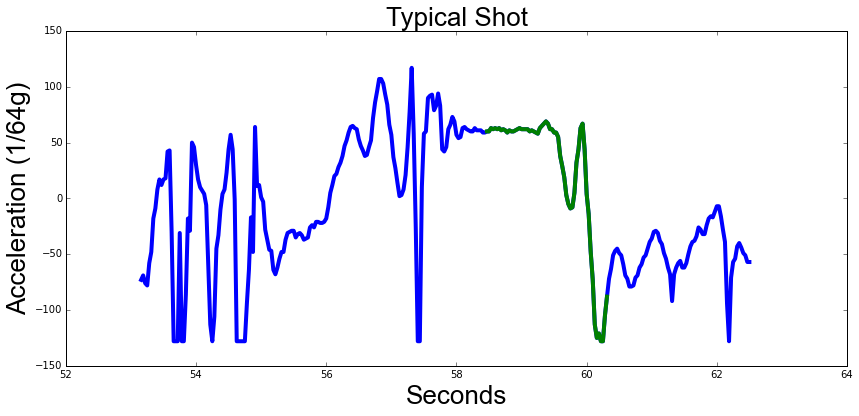

In [5]:
axis_font = {'fontname':'Arial', 'size':'26'}
plt.plot(time[1700:2000],y[1700:2000],time[1870:1930],y[1870:1930],linewidth=4)
plt.xlabel('Seconds',**axis_font)
plt.title('Typical Shot',**axis_font)
plt.ylabel('Acceleration (1/64g)',**axis_font)

plt.show()

## Processing

In order to solve the problem of classifying makes from misses to achieve predictive value, it is first necessary to automatically segment the data into individual shots. Full automation of this process will be necessary in order to eventually analyze data containing thousands of shots. This segmentation is non-trivial as the data is very noisy and contains artifacts of minute and large movements in-between shots. 

![](fig3.png)

The full set of data from a shooting session can be approximated as the signature of one shot (identified in Figure 2) convoluted with an “impulse train.” Thus, by convoluting the full set of data with the “signature shot,” we were able to obtain another sort of impulse train with peaks at the locations of the shots (Figure 3).



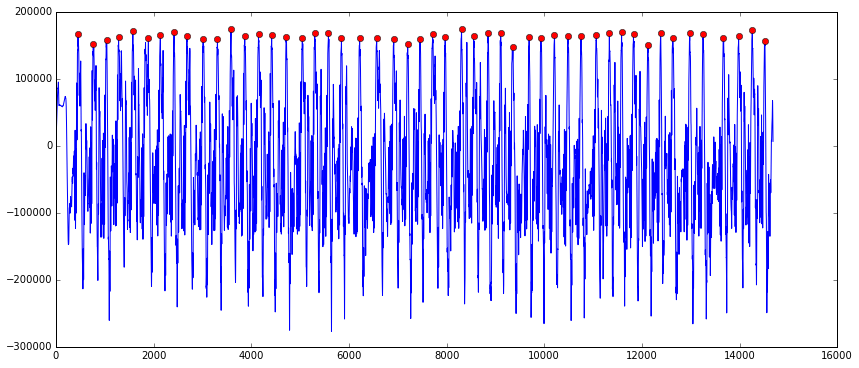

('number of shots', 50)


In [6]:
ss = y[1870:1930]

Z = np.convolve(ss,y)

import peakutils
shots = peakutils.indexes(Z, thres=.15, min_dist=200)  
shots = np.delete(shots,0)
#print (shots)
plt.plot(Z)
plt.plot(shots,Z[shots],'ro')
plt.show()

print("number of shots", np.size(shots))


### By aligning the peaks of the convolution, we can segment the data into individual shots..

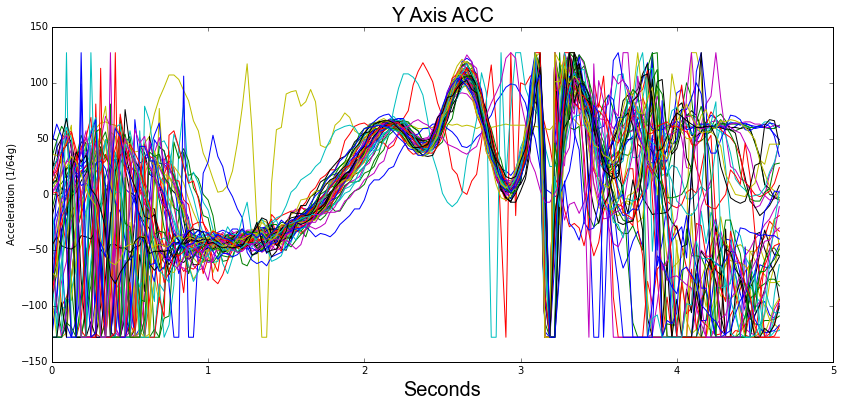

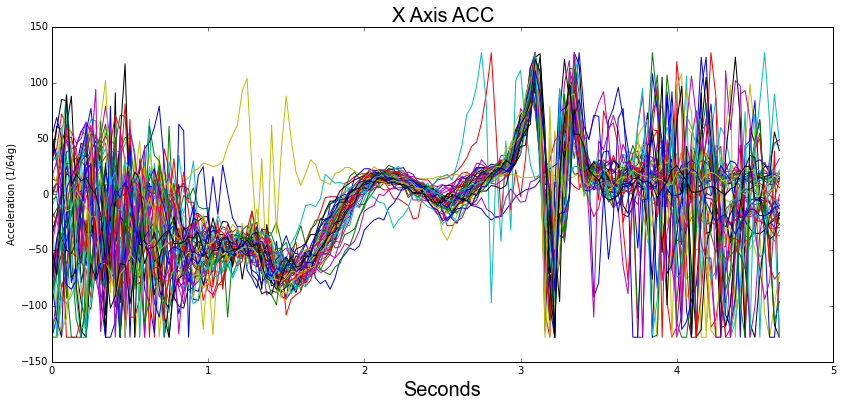

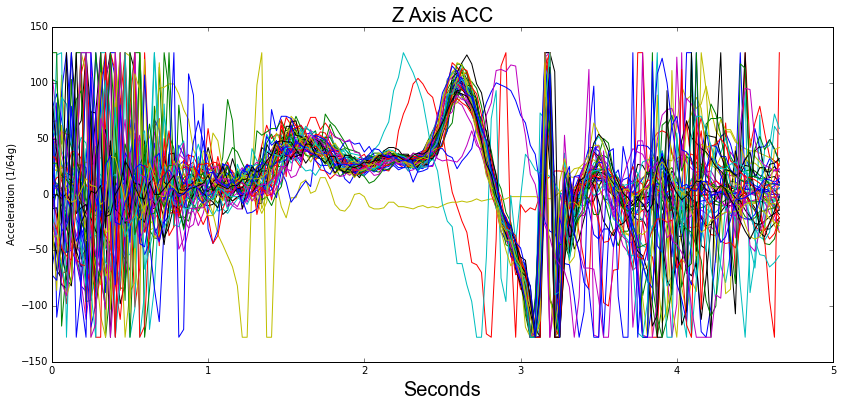

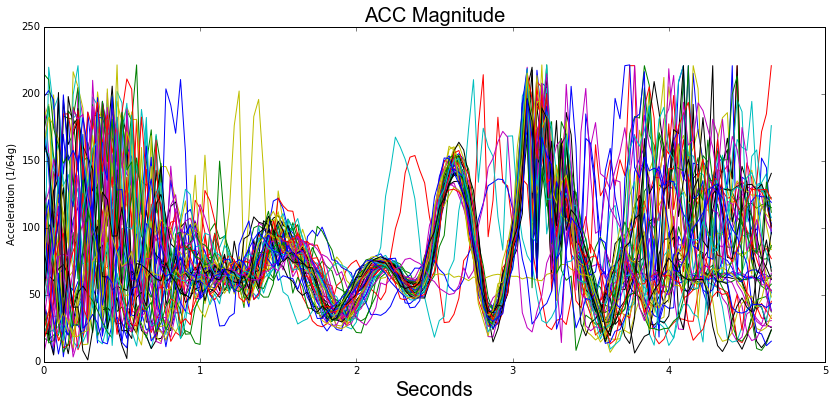

In [7]:
time2 = np.linspace(0,149,150)/32.
axis_font = {'fontname':'Arial', 'size':'20'}

for i in range(0,np.size(shots)):
    plt.plot(time2,y[(shots[i]-100):(shots[i]+50)])
plt.title('Y Axis ACC',**axis_font)
plt.xlabel('Seconds',**axis_font)
plt.ylabel('Acceleration (1/64g)')
plt.show()


for i in range(0,np.size(shots)):
    plt.plot(time2, x[(shots[i]-100):(shots[i]+50)])
plt.title('X Axis ACC',**axis_font)
plt.xlabel('Seconds',**axis_font)
plt.ylabel('Acceleration (1/64g)')
plt.show()

for i in range(0,np.size(shots)):
    plt.plot(time2, z[(shots[i]-100):(shots[i]+50)])
plt.title('Z Axis ACC',**axis_font)
plt.xlabel('Seconds',**axis_font)
plt.ylabel('Acceleration (1/64g)')
plt.show()

for i in range(0,np.size(shots)):
    plt.plot(time2, shot_mag[(shots[i]-100):(shots[i]+50)])
plt.title('ACC Magnitude',**axis_font)
plt.xlabel('Seconds',**axis_font)
plt.ylabel('Acceleration (1/64g)')
plt.show()

## Results
The filtering procedure outlined above allowed us to segment larger datasets and identify average shot patterns.

(50, 150)


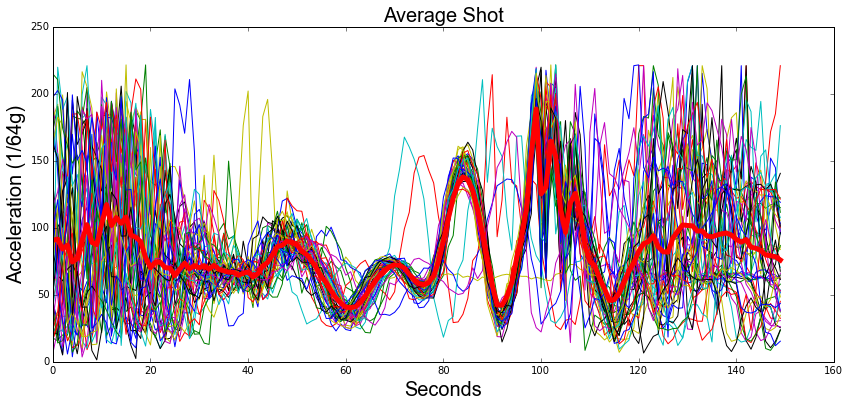

In [8]:
mag_linedup = np.zeros((np.size(shots),150))
y_linedup = np.zeros((np.size(shots),150))
x_linedup = np.zeros((np.size(shots),150))
z_linedup = np.zeros((np.size(shots),150))

for i in range(0,np.size(shots)):
    mag_linedup[i,:] = shot_mag[(shots[i]-100):(shots[i]+50)]
    y_linedup[i,:] = y[(shots[i]-100):(shots[i]+50)]
    x_linedup[i,:] = x[(shots[i]-100):(shots[i]+50)]
    z_linedup[i,:] = z[(shots[i]-100):(shots[i]+50)]

print(np.shape(mag_linedup))
avg_shot = np.mean(mag_linedup,0) 

for i in range(0,np.size(shots)):
    plt.plot(shot_mag[(shots[i]-100):(shots[i]+50)])
plt.plot(avg_shot,'r', linewidth = 5.0)
plt.xlabel('Seconds',**axis_font)
plt.title('Average Shot',**axis_font)
plt.ylabel('Acceleration (1/64g)',**axis_font)

plt.show()

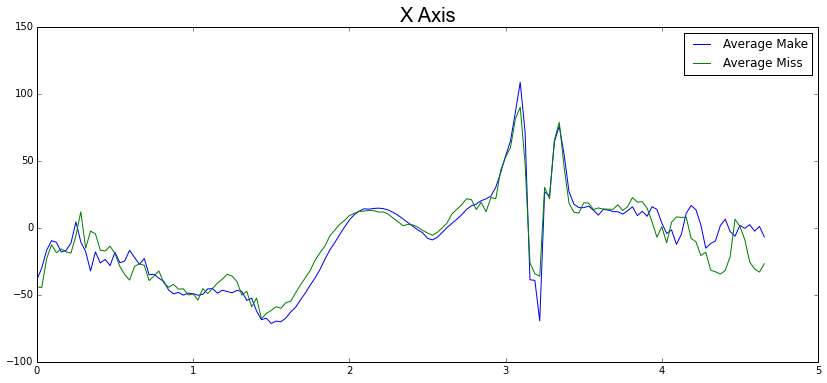

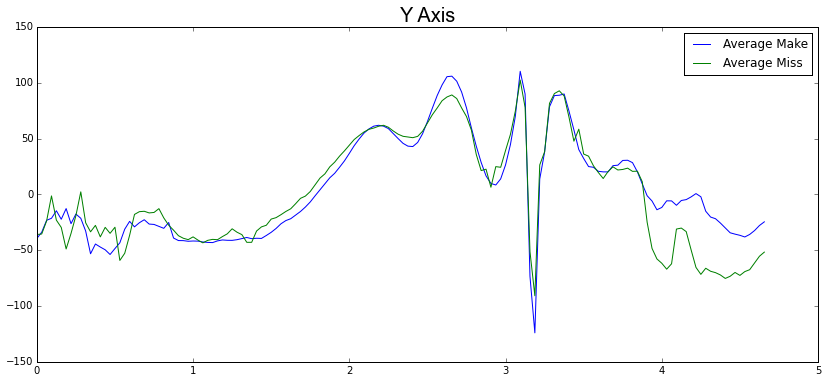

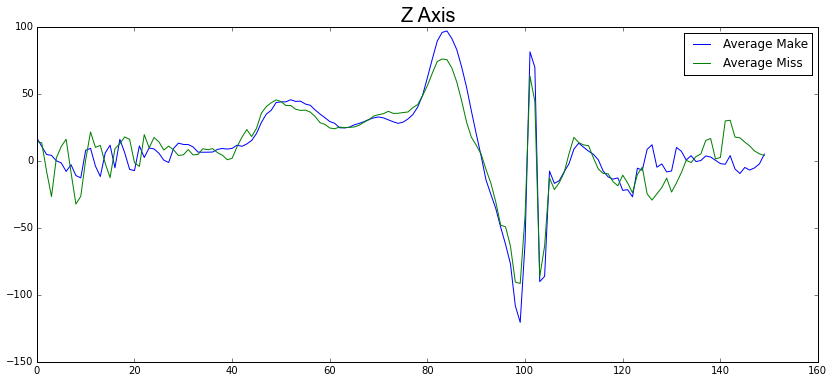

In [10]:
import csv
with open('davon_shot_makes.csv', "rt") as f:
    rawData = list(csv.reader(f))
    time_makes = np.array(rawData[:]).astype(np.float)
#print(time_makes)
outcome = time_makes[:,2]

ti = np.array(range(50))
makes = ti[outcome == 1]
misses = ti[outcome == 0]

avg_makey = np.mean(y_linedup[makes],0)
avg_missy = np.mean(y_linedup[misses],0)
avg_makex = np.mean(x_linedup[makes],0)
avg_missx = np.mean(x_linedup[misses],0)
avg_makez = np.mean(z_linedup[makes],0)
avg_missz = np.mean(z_linedup[misses],0)
timeee = np.linspace(0,np.shape(y_linedup)[1]-1,np.shape(y_linedup)[1])/32.

plt.plot(timeee,avg_makex)
plt.plot(timeee,avg_missx)
#plt.plot(avg_shot)
plt.legend({'Average Make','Average Miss'})
plt.title('X Axis',**axis_font)
plt.show()

plt.plot(timeee,avg_makey)
plt.plot(timeee,avg_missy)
#plt.plot(avg_shot)
plt.legend({'Average Make','Average Miss'})
plt.title('Y Axis',**axis_font)
plt.show()

plt.plot(avg_makez)
plt.plot(avg_missz)
#plt.plot(avg_shot)
plt.legend({'Average Make','Average Miss'})
plt.title('Z Axis',**axis_font)
plt.show()

Visually, there are some differences between the two classes of shots, leading us to believe classification is possible. Ultimately, more analysis will be required in order to identify the specific points of difference between missed and made shots via accelerometer data.



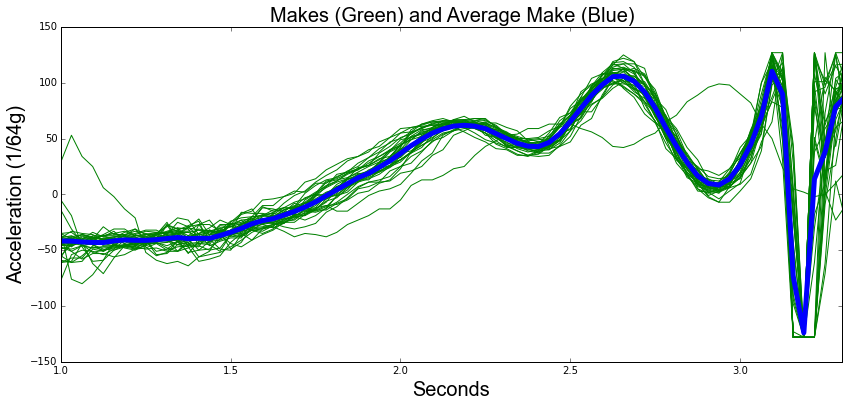

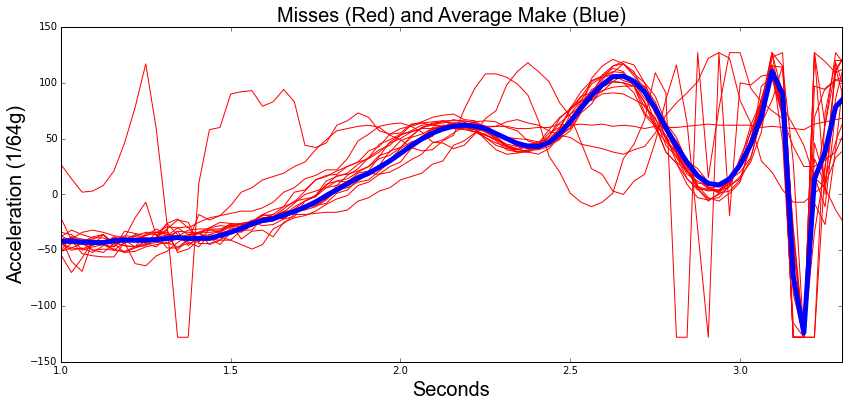

In [11]:
for r in makes:
    plt.plot(timeee,y_linedup[r,:],'g')
plt.plot(timeee,avg_makey,'b', linewidth = 5.0)
plt.xlabel('Seconds',**axis_font)
plt.title('Makes (Green) and Average Make (Blue)',**axis_font)
plt.ylabel('Acceleration (1/64g)',**axis_font)
plt.xlim([1,3.3])
plt.show()

for l in misses:
     plt.plot(timeee,y_linedup[l,:],'r')
plt.plot(timeee,avg_makey, 'b', linewidth = 5.0)
#avg_missy = np.mean(y_linedup[misses],0)
plt.xlabel('Seconds',**axis_font)
plt.title('Misses (Red) and Average Make (Blue)',**axis_font)
plt.ylabel('Acceleration (1/64g)',**axis_font)
plt.xlim([1,3.3])
plt.show()

## Principal Component Analysis

Next, PCA was performed on the full set of shots from each shooter. The uneven distribution of eigenvalues suggests a lower dimensional representation of the shot exists. About 75% of the variability in each shot is contained in the first 10 eigenvalues using a sample of 50 shots. Figure 9 shows the projection of a single shot onto the first two eigenvectors. 


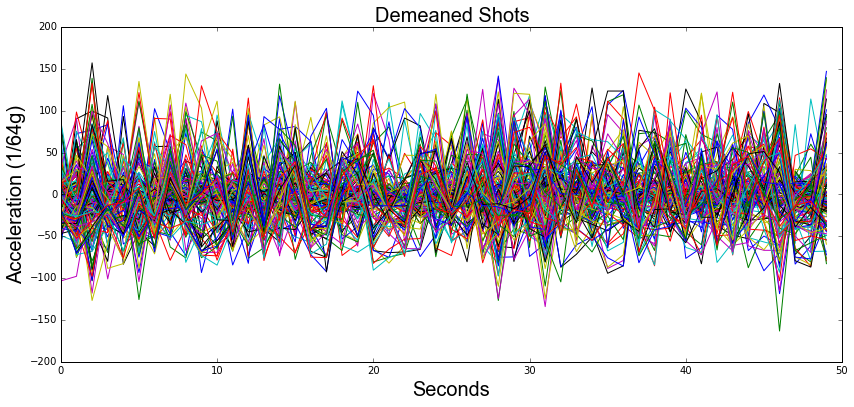

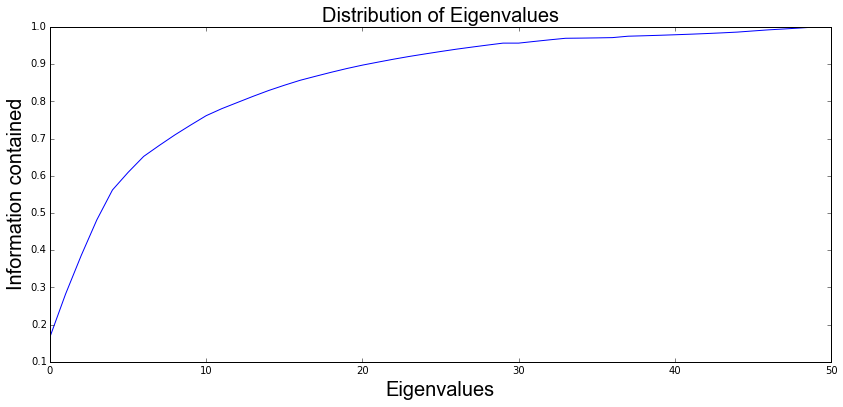

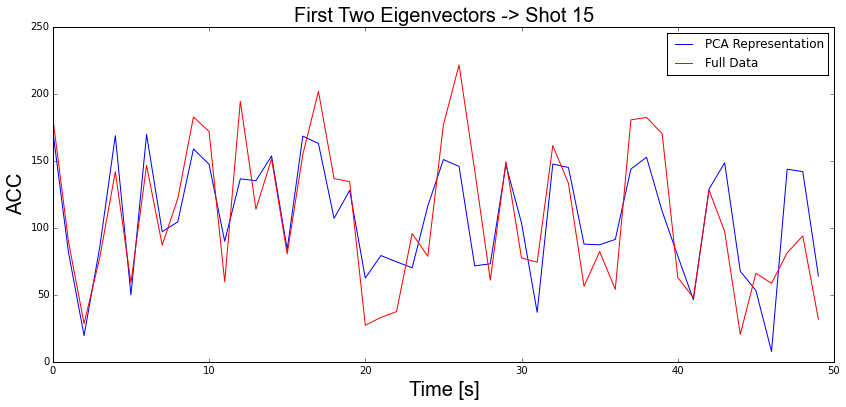

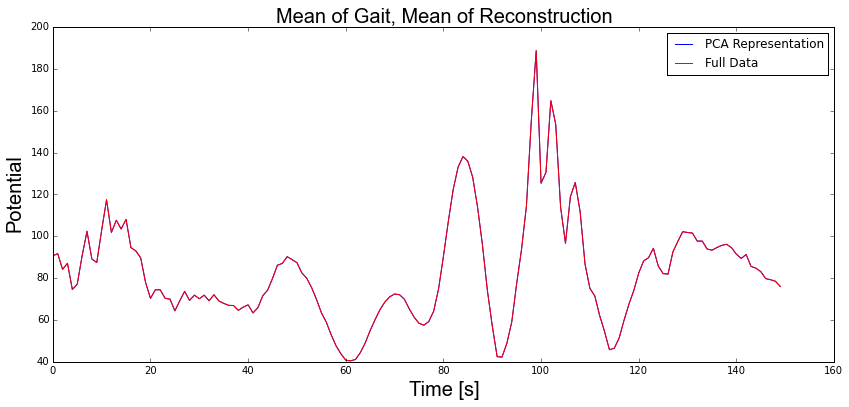

In [12]:
#PCA
mag_linedup_nomean = demean(mag_linedup)
plt.plot(mag_linedup_nomean)
plt.xlabel('Seconds',**axis_font)
plt.title('Demeaned Shots',**axis_font)
plt.ylabel('Acceleration (1/64g)',**axis_font)

plt.show()

C = np.cov(mag_linedup_nomean)
np.shape(C)
D, U = np.linalg.eig(C)

plt.plot(np.cumsum(D)/np.sum(D))
plt.xlabel('Eigenvalues',**axis_font)
plt.ylabel('Information contained',**axis_font)
plt.title('Distribution of Eigenvalues',**axis_font)
plt.show()
#print(np.shape(mag_linedup))
W = U[:,:2].T
ms = np.tile(avg_shot, (np.size(shots),1))
Y = np.dot(W,mag_linedup-ms) 

Xr = (W.T).dot(Y) + np.tile(avg_shot, (np.size(shots),1))

plt.plot(Xr[:,15], '-b', label='PCA Representation')
plt.plot(mag_linedup[:,15], '-r', label='Full Data')
plt.legend(loc='upper right')
plt.title('First Two Eigenvectors -> Shot 15',**axis_font)
plt.xlabel('Time [s]',**axis_font)
plt.ylabel('ACC',**axis_font)
plt.show()


plt.plot(np.mean(Xr,0), '-b', label='PCA Representation')
plt.plot(avg_shot, '-r', label='Full Data')
plt.legend(loc='upper right')
plt.title('Mean of Gait, Mean of Reconstruction',**axis_font)
plt.xlabel('Time [s]',**axis_font)
plt.ylabel('Potential',**axis_font)
plt.show()

## Conclusion
To classify shot success and ultimately predict shots, the filtering method developed for this project will be necessary for automated segmentation of data. This will also enable processing of much larger datasets which will be necessary for further analysis. Additionally, we want to take a closer look into a number of parameters related to shot success. For example, release velocity will be approximated by integrating the accelerometer data over each shot. Further video analysis will also be used with high speed cameras and image processing to further identify variation in shots. 
